In [1]:
# !pip3 install missingpy

In [2]:
# !pip3 install scikit-learn==0.20.1  # dep for missingpy
# !pip3 install scikit-learn==0.24.1  # required for getting tree diagram

In [3]:
data_path = '../data/'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split

%matplotlib inline

In [5]:
random_state = 2021

## Year $N$

In [6]:
N = '1'
drop_cols = ['Attr37','Attr21']

In [7]:
arff = loadarff(data_path+N+'year.arff')
df = pd.DataFrame(arff[0])
df['class']= df['class'].astype('int')
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


In [8]:
df.isnull().sum().sort_values(ascending=False).head()

Attr37    2740
Attr21    1622
Attr27     311
Attr60     135
Attr45     134
dtype: int64

In [9]:
df = df.drop(drop_cols,axis='columns')
df.shape

(7027, 63)

In [10]:
df = df.drop_duplicates()
df.shape

(6945, 63)

### Split train-dev-test without NaN in dev/test

In [37]:
na_free = df.dropna()
only_na = df[~df.index.isin(na_free.index)]

assert na_free.shape[0]+only_na.shape[0] == df.shape[0]

na_free.shape, only_na.shape

((6243, 63), (702, 63))

In [39]:
X = na_free.drop('class',axis='columns')
Y = na_free['class']
(X.shape,Y.shape)

((6243, 62), (6243,))

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.4, random_state=random_state,shuffle=True,stratify=Y)

In [41]:
X_train.shape,Y_train.shape

((3745, 62), (3745,))

In [42]:
X_train = pd.concat([X_train,only_na.drop('class',axis='columns')])
Y_train = pd.concat([Y_train,only_na['class']])
X_train.shape

(4447, 62)

In [43]:
X_val,X_test,Y_val,Y_test = train_test_split(
    X_test, Y_test, test_size=0.5, random_state=random_state, shuffle=True, stratify=Y_test)

In [44]:
X_val.shape,Y_val.shape,X_test.shape,Y_test.shape

((1249, 62), (1249,), (1249, 62), (1249,))

In [45]:
# % 1s in splitted dataset
Y_train.value_counts(), Y_val.value_counts(), Y_test.value_counts()

(0    4218
 1     229
 Name: class, dtype: int64,
 0    1228
 1      21
 Name: class, dtype: int64,
 0    1228
 1      21
 Name: class, dtype: int64)

### Retain NaN in test set also

In [11]:
X = df.drop('class',axis='columns')
Y = df['class']
(X.shape,Y.shape)

((6945, 62), (6945,))

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=random_state,shuffle=True,stratify=Y)

In [13]:
# % 1s in splitted dataset
Y_train.value_counts(), Y_test.value_counts()

(0    5005
 1     203
 Name: class, dtype: int64,
 0    1669
 1      68
 Name: class, dtype: int64)

In [14]:
X_train,Y_train,X_test,Y_test = X_train.to_numpy(),Y_train.to_numpy(),X_test.to_numpy(),Y_test.to_numpy()

### Standardise

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
# scaler = None

# scaler.mean_
# scaler.scale_

# X_train = scaler.transform(X_train)

In [16]:
32.3510 in X_train

True

## Missing values

In [22]:
def build_imputer(imputer_estimator,X_train,Y_train,transform_x=True,reset_index = True,verbose=True,max_iter=10,tol=1,imputer=None,scaler=None):
    # train = pd.concat([X_train,Y_train],axis=1)
    # train['class'] = train['class'].astype('category')
    # if reset_index:
    #     train = train.reset_index(drop=True)
    
    if imputer is None:
        imputer = IterativeImputer(estimator=imputer_estimator, n_nearest_features=None, imputation_order='ascending',verbose=verbose,max_iter=max_iter,tol=tol)
        imputer = imputer.fit(X_train,Y_train)
    else:
        imputer = imputer.fit(X_train,Y_train)
        
    
    if transform_x:
        X_train = imputer.transform(X_train)
        
        #if scaler is not None:
        #    X_train = scaler.transform(X_train)
        
        return imputer,X_train
    
    return imputer


In [19]:
def make_imputation(imputer,X_test,scaler=None):
    X_test = imputer.transform(X_test)
    if scaler is not None:
        X_test = scaler.transform(X_test)
    return X_test

In [59]:
from missingpy import MissForest

imputer = MissForest(random_state=2021,verbose=1,n_jobs=4)
imputer,X_train_imp = build_imputer(None,X_train,Y_train,transform_x=True,reset_index = True,verbose=True,imputer=imputer)
# X_imputed = imputer.fit_transform(X_train)

ModuleNotFoundError: No module named 'sklearn.neighbors.base'

In [41]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


imputer_estimator=ExtraTreesRegressor(n_estimators=16, n_jobs=4, random_state=random_state, verbose=1)
imputer,X_train_imp = build_imputer(imputer_estimator,X_train,Y_train,transform_x=True,reset_index = True,verbose=True,max_iter=32,tol=0.1,scaler=scaler)
# X_imputed = imputer.fit_transform(X_train)



[IterativeImputer] Completing matrix with shape (5208, 62)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using ba

[IterativeImputer] Change: 45.4092183393671, scaled tolerance: 72.15953092496527 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (5208, 62)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

In [78]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor




imputer_estimator = RandomForestRegressor(n_estimators=16, n_jobs=4, random_state=random_state, verbose=1)
missf,X_train_imp = build_imputer(imputer_estimator,X_train,Y_train,transform_x=True,reset_index = True,verbose=True,max_iter=64,tol=0.01)
# X_imputed = imputer.fit_transform(X_train)




[IterativeImputer] Completing matrix with shape (5208, 62)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using ba

[IterativeImputer] Change: 1318409.7422021383, scaled tolerance: 303930.0 


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using ba

[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using ba

[IterativeImputer] Change: 75490.4589896875, scaled tolerance: 303930.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (5208, 62)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

In [112]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor




imputer_estimator = BayesianRidge(verbose=1)
bayes,X_train_imp = build_imputer(imputer_estimator,X_train,Y_train,transform_x=True,reset_index = True,verbose=True,max_iter=32,tol=0.001)
# X_imputed = imputer.fit_transform(X_train)


[IterativeImputer] Completing matrix with shape (5208, 62)
Convergence after  14  iterations
Convergence after  7  iterations
Convergence after  4  iterations
Convergence after  19  iterations
Convergence after  24  iterations
Convergence after  7  iterations
Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  5  iterations
Convergence after  102  iterations
Convergence after  5  iterations
Convergence after  30  iterations
Convergence after  7  iterations
Convergence after  6  iterations
Convergence after  3  iterations
Convergence after  6  iterations
Convergence after  8  iterations
Convergence after  5  iterations
Convergence after  4  iterations
Convergence after  9  iterations
Convergence after  5  iterations
Convergence after  9  iterations
Convergence after  5  iterations
Convergence after  12  iterations
Convergence after  4  iterations
Convergence after  9  iterations
Convergence after  5  iterations
Convergenc

Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  6  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
[IterativeImputer] Change: 3.0172939048513265e+31, scaled tolerance: 30393.0 
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  4  iteration

Convergence after  2  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  1  iterations
Convergence after  5  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  2  iterations
Convergence after  1  iterations
Convergence after  4  iterations
Convergence after  183  iterations
Convergence after  214  iterations
Convergence after  13  iterations
Convergence after  5  iterations
Convergence after  13  iterations
Convergence after  280  iterations
Convergence after  8  iterations
Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  1  iterations
Convergence after  20  iterations
Convergence after  24  iterations
Convergence after  21  iterations
Convergence after  11  iterations
Convergence after  1  iteration

Convergence after  7  iterations
Convergence after  14  iterations
Convergence after  6  iterations
Convergence after  4  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  6  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
[IterativeImputer] Change: 5.336957560412735e+43, scaled tolerance: 30393.0 
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iteration

Convergence after  9  iterations
Convergence after  14  iterations
Convergence after  9  iterations
Convergence after  14  iterations
Convergence after  7  iterations
Convergence after  5  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  6  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
[IterativeImputer] Change: 2.034051117408706e+49, scaled tolerance: 30393.0 
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iteratio

Convergence after  9  iterations
Convergence after  15  iterations
Convergence after  10  iterations
Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  14  iterations
Convergence after  7  iterations
Convergence after  14  iterations
Convergence after  6  iterations
Convergence after  4  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  6  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
[IterativeImputer] Change: 6.626099972404203e+57, scaled tolerance: 30393.0 
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterat

Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
[IterativeImputer] Change: 3.5201062006777665e+79, scaled tolerance: 30393.0 
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iteration

Convergence after  8  iterations
Convergence after  11  iterations
Convergence after  9  iterations
Convergence after  15  iterations
Convergence after  11  iterations
Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  14  iterations
Convergence after  7  iterations
Convergence after  14  iterations
Convergence after  6  iterations
Convergence after  4  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  6  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
[IterativeImputer] Change: 9.990630321707562e+87, scaled tolerance: 30393.0 
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  itera

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [86]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor




imputer_estimator = KNeighborsRegressor(n_jobs=4)
knn_imp,X_train_imp = build_imputer(imputer_estimator,X_train,Y_train,transform_x=True,reset_index = True,verbose=True,max_iter=32,tol=0.009,scaler=scaler)
# X_imputed = imputer.fit_transform(X_train)


[IterativeImputer] Completing matrix with shape (5208, 62)
[IterativeImputer] Change: 406723.5205087014, scaled tolerance: 273537.0 
[IterativeImputer] Change: 247190.15158119999, scaled tolerance: 273537.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (5208, 62)


In [68]:
# np.save("y1_x_imp.npy",X_imputed)

In [122]:
np.isnan(X_train_imp).any()
X_train_imp.shape, X_test.shape

((5208, 62), (1737, 62))

## sample train

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [21]:
def build_confusion_matrix(y_true,y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Not Bankrupt","Bankrupt"])
    disp = disp.plot()
    plt.show()
    
    # plt.savefig(dir_+"/cf_test-epoch"+str(e+1)+".png",transparent=True)

In [23]:
def build_model(model,X_train,Y_train,X_val,Y_val,X_test,Y_test,report_train_scores=True,impute_test=False,imputer=None,scaler=None):
    # pass the imputed train set
    
    if scaler is not None:
        X_train = scaler.transform(X_train)
    
    model = model.fit(X_train, Y_train)
    
    if impute_test:
        X_test = imputer.transform(X_test)
    
    # impute -> standardise -> predict
    if scaler is not None:
        X_test = scaler.transform(X_test)
    
    y_pred = model.predict(X_test)

    print(classification_report(Y_test, y_pred))
    build_confusion_matrix(Y_test,y_pred)
    
    if report_train_scores:
        print("For train...")
        y_pred = model.predict(X_train)
        print(classification_report(Y_train, y_pred))
    
    # print(y_pred)
    
    return model

[IterativeImputer] Completing matrix with shape (1737, 62)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1669
           1       0.00      0.00      0.00        68

    accuracy                           0.96      1737
   macro avg       0.48      0.50      0.49      1737
weighted avg       0.92      0.96      0.94      1737



<Figure size 432x288 with 0 Axes>

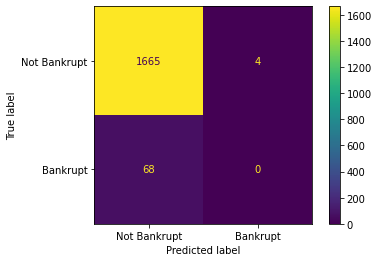

For train...
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5005
           1       1.00      0.11      0.20       203

    accuracy                           0.97      5208
   macro avg       0.98      0.55      0.59      5208
weighted avg       0.97      0.97      0.95      5208



KNeighborsClassifier(n_neighbors=2)

In [79]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
build_model(knn,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=imputer,scaler=scaler)

[IterativeImputer] Completing matrix with shape (1737, 62)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1669
           1       0.12      0.16      0.14        68

    accuracy                           0.92      1737
   macro avg       0.55      0.56      0.55      1737
weighted avg       0.93      0.92      0.93      1737



<Figure size 432x288 with 0 Axes>

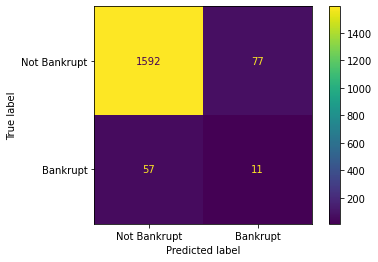

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208



DecisionTreeClassifier()

In [80]:
# DecTrees
from sklearn.tree import DecisionTreeClassifier
decTree = DecisionTreeClassifier()
build_model(decTree,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=missf,scaler=scaler)

In [81]:
# from sklearn.tree import plot_tree
# plot_tree(decTree) 

[IterativeImputer] Completing matrix with shape (1737, 62)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1669
           1       0.50      0.12      0.19        68

    accuracy                           0.96      1737
   macro avg       0.73      0.56      0.59      1737
weighted avg       0.95      0.96      0.95      1737



<Figure size 432x288 with 0 Axes>

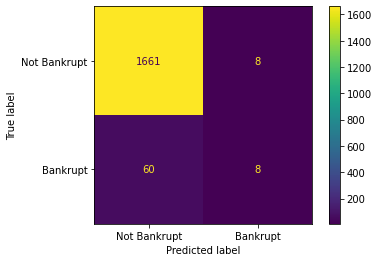

For train...
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5005
           1       0.74      0.11      0.20       203

    accuracy                           0.96      5208
   macro avg       0.85      0.56      0.59      5208
weighted avg       0.96      0.96      0.95      5208



AdaBoostClassifier()

In [82]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier()
build_model(ada,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=missf,scaler=scaler)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[IterativeImputer] Completing matrix with shape (1737, 62)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1669
           1       0.71      0.25      0.37        68

    accuracy                           0.97      1737
   macro avg       0.84      0.62      0.68      1737
weighted avg       0.96      0.97      0.96      1737



<Figure size 432x288 with 0 Axes>

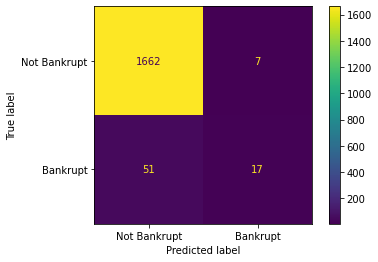

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208



In [83]:
from xgboost import XGBClassifier

xgb = XGBClassifier(scale_pos_weight=16)
xgb = build_model(xgb,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=missf,scaler=scaler)



[13:15:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1669
           1       0.74      0.34      0.46        68

    accuracy                           0.97      1737
   macro avg       0.86      0.67      0.72      1737
weighted avg       0.96      0.97      0.96      1737



<Figure size 432x288 with 0 Axes>

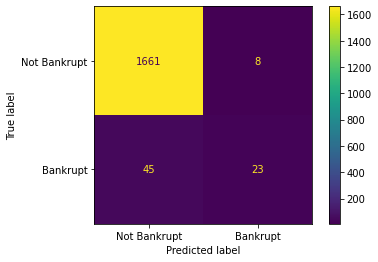

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208



In [25]:
## GOOD VALUE: KNN impute with tol 0.01 and maxiter 32 => f1=46%

from xgboost import XGBClassifier

xgb = XGBClassifier(scale_pos_weight=16)
xgb = build_model(xgb,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=knn_imp)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:04:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1669
           1       0.88      0.10      0.18        68

    accuracy                           0.96      1737
   macro avg       0.92      0.55      0.58      1737
weighted avg       0.96      0.96      0.95      1737



<Figure size 432x288 with 0 Axes>

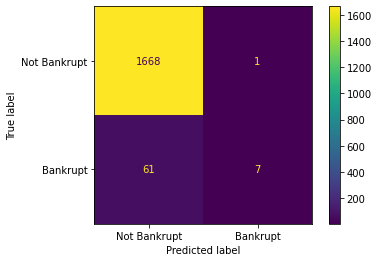

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208



In [87]:
## GOOD VALUE: KNN impute with tol 0.01 and maxiter 32 => f1=46%

from xgboost import XGBClassifier

xgb = XGBClassifier(scale_pos_weight=16)
xgb = build_model(xgb,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=knn_imp,scaler=scaler)



[IterativeImputer] Completing matrix with shape (1737, 62)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1669
           1       0.06      0.03      0.04        68

    accuracy                           0.94      1737
   macro avg       0.51      0.50      0.50      1737
weighted avg       0.93      0.94      0.93      1737



<Figure size 432x288 with 0 Axes>

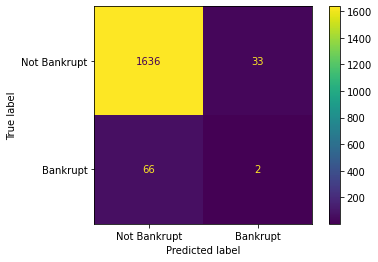

For train...
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5005
           1       1.00      0.02      0.05       203

    accuracy                           0.96      5208
   macro avg       0.98      0.51      0.51      5208
weighted avg       0.96      0.96      0.94      5208



LogisticRegression(max_iter=1024)

In [84]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(max_iter=1024)
build_model(logistic,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=missf,scaler=scaler)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


[IterativeImputer] Completing matrix with shape (1737, 62)


[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using ba

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1669
           1       0.12      0.01      0.03        68

    accuracy                           0.96      1737
   macro avg       0.54      0.51      0.50      1737
weighted avg       0.93      0.96      0.94      1737



<Figure size 432x288 with 0 Axes>

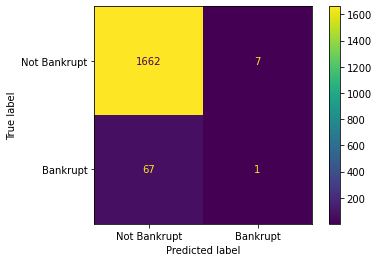

For train...
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5005
           1       0.99      0.87      0.93       203

    accuracy                           0.99      5208
   macro avg       0.99      0.94      0.96      5208
weighted avg       0.99      0.99      0.99      5208



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished


RandomForestClassifier(n_estimators=16, n_jobs=4, random_state=2021, verbose=1)

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

ada = RandomForestClassifier(n_estimators=16, n_jobs=4, random_state=random_state, verbose=1)
build_model(ada,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=missf,scaler=scaler)

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca = pca.fit(X_train_imp)

In [27]:
X_train_imp_pca = pca.transform(X_train_imp)

[IterativeImputer] Completing matrix with shape (1737, 62)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1669
           1       0.22      0.03      0.05        68

    accuracy                           0.96      1737
   macro avg       0.59      0.51      0.52      1737
weighted avg       0.93      0.96      0.94      1737



<Figure size 432x288 with 0 Axes>

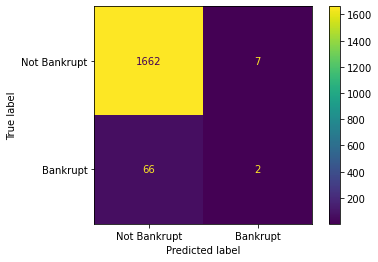

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208



In [29]:
from xgboost import XGBClassifier

xgb = XGBClassifier(scale_pos_weight=16)
xgb = build_model(xgb,X_train_imp_pca,Y_train,None,None,pca.transform(knn_imp.transform(X_test)),Y_test,impute_test=False)



## Combining...

KNeighborsRegressor(n_jobs=4)
[IterativeImputer] Completing matrix with shape (5208, 62)
[IterativeImputer] Change: 406723.5205087014, scaled tolerance: 303930.0 
[IterativeImputer] Change: 247190.15158119999, scaled tolerance: 303930.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (5208, 62)
KNeighborsClassifier(n_neighbors=2)
W/o scaling...
[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1669
           1       0.00      0.00      0.00        68

    accuracy                           0.96      1737
   macro avg       0.48      0.50      0.49      1737
weighted avg       0.92      0.96      0.94      1737



<Figure size 432x288 with 0 Axes>

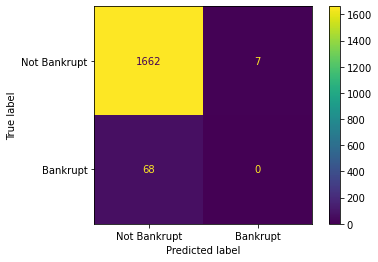

For train...
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5005
           1       1.00      0.08      0.15       203

    accuracy                           0.96      5208
   macro avg       0.98      0.54      0.57      5208
weighted avg       0.97      0.96      0.95      5208

[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1669
           1       0.00      0.00      0.00        68

    accuracy                           0.96      1737
   macro avg       0.48      0.50      0.49      1737
weighted avg       0.92      0.96      0.94      1737



<Figure size 432x288 with 0 Axes>

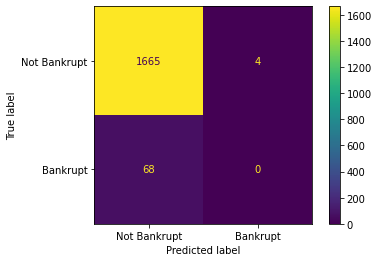

For train...
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5005
           1       1.00      0.12      0.21       203

    accuracy                           0.97      5208
   macro avg       0.98      0.56      0.60      5208
weighted avg       0.97      0.97      0.95      5208

DecisionTreeClassifier()
W/o scaling...
[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1669
           1       0.22      0.25      0.23        68

    accuracy                           0.94      1737
   macro avg       0.60      0.61      0.60      1737
weighted avg       0.94      0.94      0.94      1737



<Figure size 432x288 with 0 Axes>

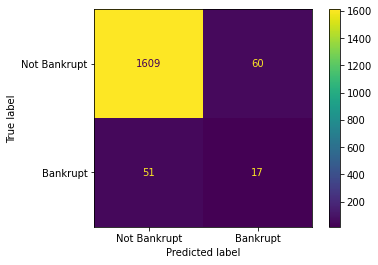

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208

[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1669
           1       0.20      0.24      0.21        68

    accuracy                           0.93      1737
   macro avg       0.58      0.60      0.59      1737
weighted avg       0.94      0.93      0.94      1737



<Figure size 432x288 with 0 Axes>

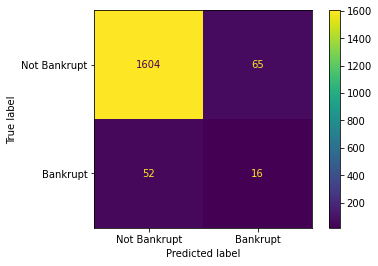

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208

AdaBoostClassifier()
W/o scaling...
[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1669
           1       0.39      0.10      0.16        68

    accuracy                           0.96      1737
   macro avg       0.68      0.55      0.57      1737
weighted avg       0.94      0.96      0.95      1737



<Figure size 432x288 with 0 Axes>

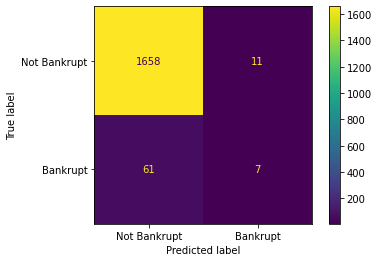

For train...
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5005
           1       0.81      0.14      0.24       203

    accuracy                           0.97      5208
   macro avg       0.89      0.57      0.61      5208
weighted avg       0.96      0.97      0.95      5208

[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1669
           1       0.38      0.09      0.14        68

    accuracy                           0.96      1737
   macro avg       0.67      0.54      0.56      1737
weighted avg       0.94      0.96      0.95      1737



<Figure size 432x288 with 0 Axes>

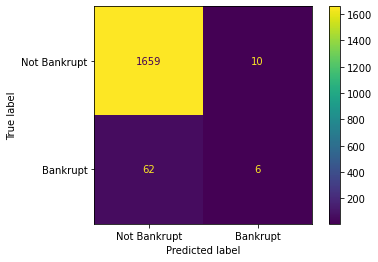

For train...
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5005
           1       0.75      0.15      0.25       203

    accuracy                           0.96      5208
   macro avg       0.86      0.57      0.61      5208
weighted avg       0.96      0.96      0.95      5208

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=16, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
W/o scaling...


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:39:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1669
           1       0.74      0.34      0.46        68

    accuracy                           0.97      1737
   macro avg       0.86      0.67      0.72      1737
weighted avg       0.96      0.97      0.96      1737



<Figure size 432x288 with 0 Axes>

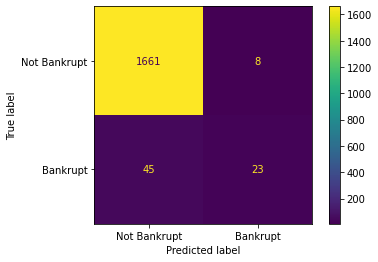

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208

[21:39:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1669
           1       0.77      0.34      0.47        68

    accuracy                           0.97      1737
   macro avg       0.87      0.67      0.73      1737
weighted avg       0.97      0.97      0.96      1737



<Figure size 432x288 with 0 Axes>

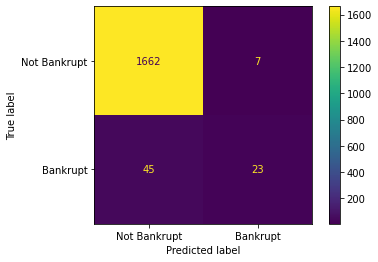

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208




ExtraTreesRegressor(n_estimators=16, n_jobs=4, random_state=2021)
[IterativeImputer] Completing matrix with shape (5208, 62)
[IterativeImputer] Change: 389723.6472759469, scaled tolerance: 303930.0 
[IterativeImputer] Change: 243397.34098187496, scaled tolerance: 303930.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (5208, 62)
KNeighborsClassifier(n_neighbors=2)
W/o scaling...
[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1669
           1       0.00      0.00      0.00        6

<Figure size 432x288 with 0 Axes>

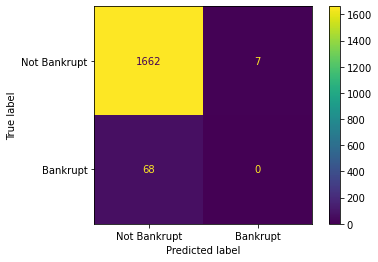

For train...
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5005
           1       1.00      0.08      0.15       203

    accuracy                           0.96      5208
   macro avg       0.98      0.54      0.57      5208
weighted avg       0.97      0.96      0.95      5208

[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1669
           1       0.00      0.00      0.00        68

    accuracy                           0.96      1737
   macro avg       0.48      0.50      0.49      1737
weighted avg       0.92      0.96      0.94      1737



<Figure size 432x288 with 0 Axes>

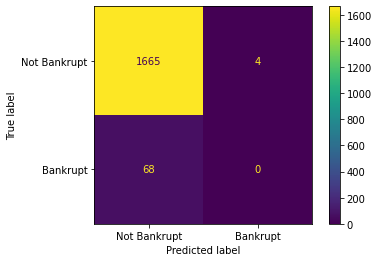

For train...
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5005
           1       1.00      0.11      0.20       203

    accuracy                           0.97      5208
   macro avg       0.98      0.56      0.59      5208
weighted avg       0.97      0.97      0.95      5208

DecisionTreeClassifier()
W/o scaling...
[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1669
           1       0.18      0.24      0.20        68

    accuracy                           0.93      1737
   macro avg       0.57      0.60      0.58      1737
weighted avg       0.94      0.93      0.93      1737



<Figure size 432x288 with 0 Axes>

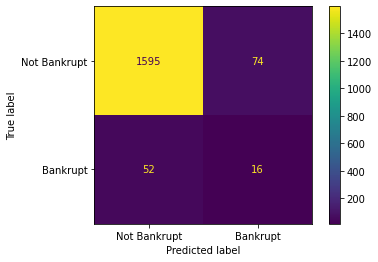

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208

[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1669
           1       0.14      0.19      0.16        68

    accuracy                           0.92      1737
   macro avg       0.55      0.57      0.56      1737
weighted avg       0.93      0.92      0.93      1737



<Figure size 432x288 with 0 Axes>

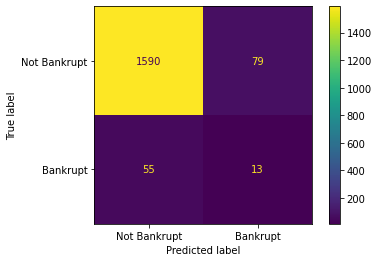

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208

AdaBoostClassifier()
W/o scaling...
[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1669
           1       0.47      0.12      0.19        68

    accuracy                           0.96      1737
   macro avg       0.72      0.56      0.58      1737
weighted avg       0.95      0.96      0.95      1737



<Figure size 432x288 with 0 Axes>

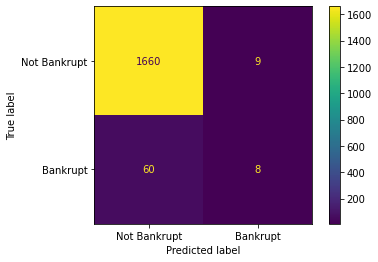

For train...
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5005
           1       0.88      0.14      0.24       203

    accuracy                           0.97      5208
   macro avg       0.92      0.57      0.61      5208
weighted avg       0.96      0.97      0.95      5208

[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1669
           1       0.36      0.07      0.12        68

    accuracy                           0.96      1737
   macro avg       0.66      0.53      0.55      1737
weighted avg       0.94      0.96      0.95      1737



<Figure size 432x288 with 0 Axes>

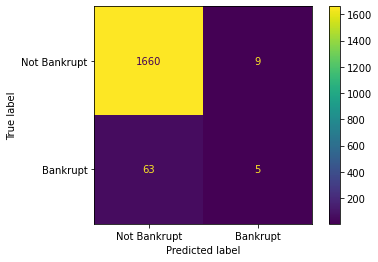

For train...
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5005
           1       0.73      0.12      0.20       203

    accuracy                           0.96      5208
   macro avg       0.85      0.56      0.59      5208
weighted avg       0.96      0.96      0.95      5208

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=16, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
W/o scaling...


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:42:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1669
           1       0.45      0.13      0.20        68

    accuracy                           0.96      1737
   macro avg       0.71      0.56      0.59      1737
weighted avg       0.95      0.96      0.95      1737



<Figure size 432x288 with 0 Axes>

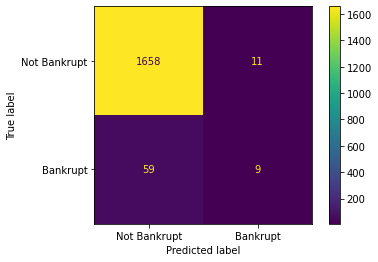

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208

[21:43:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1669
           1       0.60      0.22      0.32        68

    accuracy                           0.96      1737
   macro avg       0.78      0.61      0.65      1737
weighted avg       0.95      0.96      0.96      1737



<Figure size 432x288 with 0 Axes>

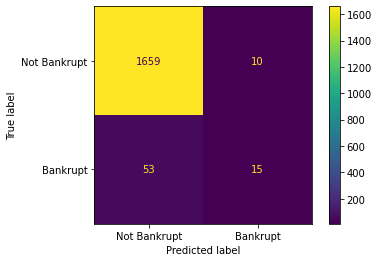

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208




RandomForestRegressor(n_estimators=16, n_jobs=4, random_state=2021)
[IterativeImputer] Completing matrix with shape (5208, 62)
[IterativeImputer] Change: 1318409.7422021383, scaled tolerance: 303930.0 
[IterativeImputer] Change: 75490.45898968751, scaled tolerance: 303930.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (5208, 62)
KNeighborsClassifier(n_neighbors=2)
W/o scaling...
[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1669
           1       0.00      0.00      0.00       

<Figure size 432x288 with 0 Axes>

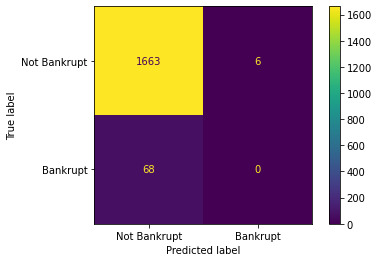

For train...
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5005
           1       1.00      0.08      0.15       203

    accuracy                           0.96      5208
   macro avg       0.98      0.54      0.56      5208
weighted avg       0.97      0.96      0.95      5208

[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1669
           1       0.00      0.00      0.00        68

    accuracy                           0.96      1737
   macro avg       0.48      0.50      0.49      1737
weighted avg       0.92      0.96      0.94      1737



<Figure size 432x288 with 0 Axes>

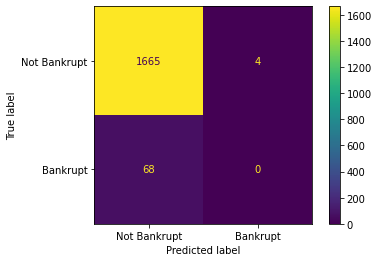

For train...
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5005
           1       1.00      0.11      0.20       203

    accuracy                           0.97      5208
   macro avg       0.98      0.55      0.59      5208
weighted avg       0.97      0.97      0.95      5208

DecisionTreeClassifier()
W/o scaling...
[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1669
           1       0.12      0.15      0.13        68

    accuracy                           0.93      1737
   macro avg       0.54      0.55      0.55      1737
weighted avg       0.93      0.93      0.93      1737



<Figure size 432x288 with 0 Axes>

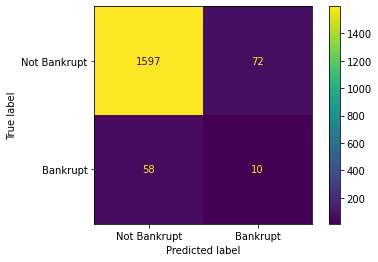

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208

[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1669
           1       0.11      0.13      0.12        68

    accuracy                           0.92      1737
   macro avg       0.54      0.54      0.54      1737
weighted avg       0.93      0.92      0.93      1737



<Figure size 432x288 with 0 Axes>

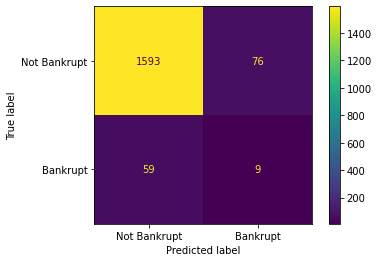

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208

AdaBoostClassifier()
W/o scaling...
[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1669
           1       0.44      0.06      0.10        68

    accuracy                           0.96      1737
   macro avg       0.70      0.53      0.54      1737
weighted avg       0.94      0.96      0.95      1737



<Figure size 432x288 with 0 Axes>

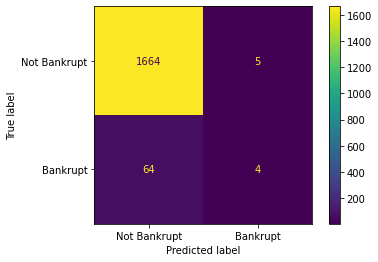

For train...
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5005
           1       0.71      0.12      0.21       203

    accuracy                           0.96      5208
   macro avg       0.84      0.56      0.60      5208
weighted avg       0.96      0.96      0.95      5208

[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1669
           1       0.30      0.04      0.08        68

    accuracy                           0.96      1737
   macro avg       0.63      0.52      0.53      1737
weighted avg       0.94      0.96      0.94      1737



<Figure size 432x288 with 0 Axes>

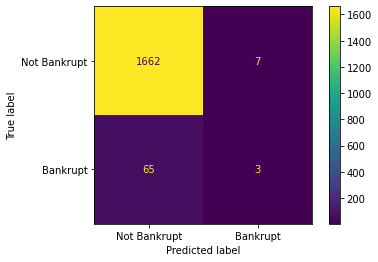

For train...
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5005
           1       0.74      0.11      0.20       203

    accuracy                           0.96      5208
   macro avg       0.85      0.56      0.59      5208
weighted avg       0.96      0.96      0.95      5208

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=16, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
W/o scaling...
[21:49:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learn

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1669
           1       0.56      0.13      0.21        68

    accuracy                           0.96      1737
   macro avg       0.76      0.56      0.60      1737
weighted avg       0.95      0.96      0.95      1737



<Figure size 432x288 with 0 Axes>

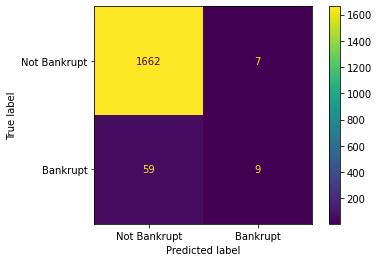

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208

[21:49:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1669
           1       0.70      0.24      0.35        68

    accuracy                           0.97      1737
   macro avg       0.83      0.62      0.67      1737
weighted avg       0.96      0.97      0.96      1737



<Figure size 432x288 with 0 Axes>

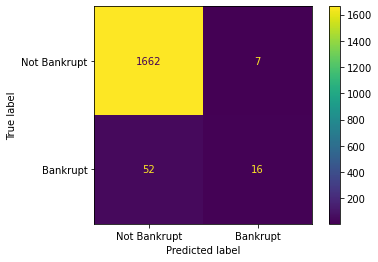

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208




BayesianRidge(verbose=0)
[IterativeImputer] Completing matrix with shape (5208, 62)
[IterativeImputer] Change: 3350565872350.275, scaled tolerance: 303930.0 
[IterativeImputer] Change: 2.7746710010331655e+21, scaled tolerance: 303930.0 
[IterativeImputer] Change: 1.6682264058124632e+38, scaled tolerance: 303930.0 
[IterativeImputer] Change: 1.6682264058221537e+38, scaled tolerance: 303930.0 
[IterativeImputer] Change: 3.0172939048513265e+31, scaled tolerance: 303930.0 
[IterativeImputer] Change: 1.8561377173502028e+45, scaled tolerance: 303930.0 
[IterativeImputer] Change: 1.8561377173501755e+45, scaled tolerance: 303930.0 


KeyboardInterrupt: 

In [27]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, AdaBoostClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from xgboost import XGBClassifier


all_imputers = [KNeighborsRegressor(n_jobs=4),ExtraTreesRegressor(n_estimators=16, n_jobs=4, random_state=random_state, verbose=0),RandomForestRegressor(n_estimators=16, n_jobs=4, random_state=random_state, verbose=0),BayesianRidge(verbose=0)]

all_trainers = [KNeighborsClassifier(n_neighbors=2),DecisionTreeClassifier(),AdaBoostClassifier(),XGBClassifier(scale_pos_weight=16)]

for imputer_estimator in all_imputers:
    print(imputer_estimator)
    imputer,X_train_imp = build_imputer(imputer_estimator,X_train,Y_train,transform_x=True,reset_index = True,verbose=True,max_iter=32,tol=0.01,scaler=scaler)

    for trainer in all_trainers:
        print(trainer)

        # print("W/o scaling and W/o imputing...")
        # build_model(trainer,X_train,Y_train,None,None,X_test,Y_test,impute_test=False,scaler=None)

        # print("W/o imputing...")
        # build_model(trainer,X_train,Y_train,None,None,X_test,Y_test,impute_test=False,scaler=scaler)

        print("W/o scaling...")
        build_model(trainer,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=imputer,scaler=None)


        # print("Scaling AND imputing...")
        build_model(trainer,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=imputer,scaler=scaler)

        # print("",end='\n\n')


    print("",end='\n\n\n')




In [41]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, AdaBoostClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from xgboost import XGBClassifier


all_imputers = [KNeighborsRegressor(n_jobs=4)]
imputer=None
X_train_imp=None

for imputer_estimator in all_imputers:
    print(imputer_estimator)
    imputer,X_train_imp = build_imputer(imputer_estimator,X_train,Y_train,transform_x=True,reset_index = True,verbose=True,max_iter=32,tol=0.01,scaler=scaler)


KNeighborsRegressor(n_jobs=4)
[IterativeImputer] Completing matrix with shape (5208, 62)
[IterativeImputer] Change: 406723.5205087014, scaled tolerance: 303930.0 
[IterativeImputer] Change: 247190.15158119999, scaled tolerance: 303930.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (5208, 62)


### Various Classification Models

In [29]:
# !pip3 install imblearn

     |████████████████████████████████| 206 kB 2.0 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [42]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [43]:
def try_all_classifiers(X_train, X_test, y_train, y_test, classifiers, sampling  = None):
    accuracy = [0]*len(classifiers)
    f1 = [0]*len(classifiers)
    precision = [0]*len(classifiers)
    recall = [0]*len(classifiers)
    i = 0
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=1, shuffle = True)
    if sampling == "SMOTE":
        smote = SMOTE()
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print("SMOTE")
    if sampling == "RUS":
        rus = RandomUnderSampler()
        X_train, y_train = rus.fit_resample(X_train, y_train)
        print("RUS")
    
    for i in range(len(classifiers)):
        classif = classifiers[i]
        classif.fit(X_train, y_train)
        y_pred = classif.predict(X_test)
        
        accuracy[i] = classif.score(X_test, y_test)
        f1[i] = metrics.f1_score(y_test, y_pred, labels=np.unique(y_pred))
        precision[i] = metrics.precision_score(y_test, y_pred)
        recall[i] = metrics.recall_score(y_test, y_pred)
    print("Done")
    return accuracy,f1,precision,recall

In [44]:
classifiers_names = ["Logistic Regression", "LDA", "KNN 5", "KNN 10", "GNB", "DT", "SVM", "RFC", "XGB"]
classifiers = [LogisticRegression(), LinearDiscriminantAnalysis(),KNeighborsClassifier(n_neighbors=5), KNeighborsClassifier(n_neighbors=10),GaussianNB(),DecisionTreeClassifier(),SVC(),RandomForestClassifier(),XGBClassifier(use_label_encoder=False)]

In [45]:
accuracy,f1,precision,recall = try_all_classifiers(scaler.transform(X_train_imp),scaler.transform(imputer.transform(X_test)),Y_train,Y_test, classifiers)


[IterativeImputer] Completing matrix with shape (1737, 62)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[22:05:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Done


### Sampling

In [46]:
accuracy_sm,f1_sm,precision_sm,recall_sm = try_all_classifiers(scaler.transform(X_train_imp),scaler.transform(imputer.transform(X_test)),Y_train,Y_test, classifiers, sampling = "SMOTE")



[IterativeImputer] Completing matrix with shape (1737, 62)
SMOTE


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[22:06:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Done


In [ ]:
## scaler.transform(X_train_imp),scaler.transform(imputer.transform(X_test)),Y_train,Y_test,

In [47]:
accuracy_rus,f1_rus,precision_rus,recall_rus = try_all_classifiers(scaler.transform(X_train_imp),scaler.transform(imputer.transform(X_test)),Y_train,Y_test, classifiers, sampling = "RUS")

[IterativeImputer] Completing matrix with shape (1737, 62)
RUS
[22:06:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Done


In [48]:
accuracy_table = np.vstack((classifiers_names, accuracy, accuracy_sm, accuracy_rus))
display(accuracy_table)

array([['Logistic Regression', 'LDA', 'KNN 5', 'KNN 10', 'GNB', 'DT',
        'SVM', 'RFC', 'XGB'],
       ['0.9585492227979274', '0.9568221070811744', '0.9608520437535981',
        '0.9608520437535981', '0.07944732297063903',
        '0.9424294761082326', '0.9608520437535981', '0.9591249280368451',
        '0.9666090961427749'],
       ['0.6557282671272309', '0.6718480138169257', '0.8013816925734024',
        '0.7892918825561313', '0.09326424870466321',
        '0.8825561312607945', '0.49971214738054115', '0.945308002302821',
        '0.9660333909038572'],
       ['0.6505469199769718', '0.6321243523316062', '0.6361542890040299',
        '0.7512953367875648', '0.9211283822682786', '0.6603339090385723',
        '0.567069660333909', '0.713874496257916', '0.7340241796200345']],
      dtype='<U32')

In [49]:
f1_table = np.vstack((classifiers_names, f1, f1_sm, f1_rus))
display(f1_table)

array([['Logistic Regression', 'LDA', 'KNN 5', 'KNN 10', 'GNB', 'DT',
        'SVM', 'RFC', 'XGB'],
       ['0.0', '0.0', '0.028571428571428574', '0.0',
        '0.07625649913344888', '0.28571428571428575', '0.0',
        '0.0273972602739726', '0.3409090909090909'],
       ['0.14814814814814814', '0.1467065868263473',
        '0.15647921760391198', '0.1527777777777778',
        '0.07624633431085044', '0.22727272727272727',
        '0.11416921508664628', '0.21487603305785125',
        '0.4957264957264957'],
       ['0.14386459802538784', '0.14228187919463087',
        '0.10734463276836159', '0.12195121951219512',
        '0.05517241379310345', '0.13235294117647062',
        '0.1026252983293556', '0.1785123966942149',
        '0.18661971830985916']], dtype='<U32')

In [50]:
precision_table = np.vstack((classifiers_names,precision, precision_sm, precision_rus))
display(precision_table)

array([['Logistic Regression', 'LDA', 'KNN 5', 'KNN 10', 'GNB', 'DT',
        'SVM', 'RFC', 'XGB'],
       ['0.0', '0.0', '0.5', '0.0', '0.0396873120865905',
        '0.2777777777777778', '0.0', '0.2', '0.75'],
       ['0.08201892744479496', '0.08166666666666667',
        '0.093841642228739', '0.09065934065934066',
        '0.03970678069639585', '0.15306122448979592',
        '0.06133625410733844', '0.24528301886792453',
        '0.5918367346938775'],
       ['0.07956318252730109', '0.07828655834564253', '0.059375',
        '0.07075471698113207', '0.05194805194805195',
        '0.07352941176470588', '0.05584415584415584',
        '0.1005586592178771', '0.106']], dtype='<U32')

In [51]:
recall_table = np.vstack((classifiers_names,recall, recall_sm, recall_rus))
display(recall_table)

array([['Logistic Regression', 'LDA', 'KNN 5', 'KNN 10', 'GNB', 'DT',
        'SVM', 'RFC', 'XGB'],
       ['0.0', '0.0', '0.014705882352941176', '0.0',
        '0.9705882352941176', '0.29411764705882354', '0.0',
        '0.014705882352941176', '0.22058823529411764'],
       ['0.7647058823529411', '0.7205882352941176',
        '0.47058823529411764', '0.4852941176470588',
        '0.9558823529411765', '0.4411764705882353', '0.8235294117647058',
        '0.19117647058823528', '0.4264705882352941'],
       ['0.75', '0.7794117647058824', '0.5588235294117647',
        '0.4411764705882353', '0.058823529411764705',
        '0.6617647058823529', '0.6323529411764706', '0.7941176470588235',
        '0.7794117647058824']], dtype='<U32')